In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.fft import fft, fftshift
import numpy as np
import scipy as sp

from scipy.fft import fft
from scipy import signal
from scipy.io import wavfile

from google.colab import files

from IPython.display import Audio, display

In [2]:
def Play(x, fd):
  display(Audio(x, rate=fd, autoplay=False))

def readWav(path):
  samplerate, x = wavfile.read(path)
  x = x.mean(axis=1)
  return (samplerate, x)


def freqsToNotes(freqs):
  return list(map(findClosestNote, freqs))


In [7]:

def listOfNotes():
  notes = {}
  basic = 27.5 # базовая частота ноты
  factor = 2.0 ** (1.0/12.0)  # фактор увеличения частоты
  for i in range(-3, 6): # пробегаем все октавы
    # Для каждой ноты в октаве
    # вычисляется ее звуковая частота и добавляется в словарь
    notes[('A', i)] = basic; basic *= factor;
    notes[('A#', i)] = basic; basic *= factor;
    notes[('B', i)] = basic; basic *= factor;
    i += 1
    notes[('C', i)] = basic; basic *= factor;
    notes[('C#', i)] = basic; basic *= factor;
    notes[('D', i)] = basic; basic *= factor;
    notes[('D#', i)] = basic; basic *= factor;
    notes[('E', i)] = basic; basic *= factor;
    notes[('F', i)] = basic; basic *= factor;
    notes[('F#', i)] = basic; basic *= factor;
    notes[('G', i)] = basic; basic *= factor;
    notes[('G#', i)] = basic; basic *= factor;
    i -= 1
  return notes


def findClosestNote(freq):
  d = {}
  for key, value in notes.items():
    d[key] = abs(value - freq)
  min_note = min(d, key=d.get)  # поиск ключа с минимальным значением
  min_dist = d[min_note]  # мин расстояния до ближайшей ноты
  return (min_note, min_dist)


def findMainFreqs(x, samplerate, factor, order):
    X = sp.fft.fft(x - np.mean(x)) # Фурье -> спектр.
    f = sp.fft.fftfreq(len(x), 1.0/samplerate) # Вычисляем частоты, соответствующие каждой компоненте спектра
    max_X = max(abs(X)) # максимальное значение амплитуды в спектре
    new_X = np.array(list(map(lambda el: el if abs(el) > max_X * factor else 0, X)))
    # Ищем локальные максимумы в отфильтрованном спектре
    best_freqs = f[signal.argrelmax(new_X, order=order)]
    # Возвращаем только положительные частоты
    return list(filter(lambda el: el > 0, best_freqs))

In [20]:

def analyseSignal(path, factor=1.0/5, time_segments=10, order=10, threshold=0.5, reliablity_distance=1.5):
    samplerate, x = readWav(path) # Чтение и частота дискретизации и сигнала
    n = len(x) // time_segments # Вычисление длины сегмента

    for i in range(time_segments):
        tmp_x = x[i*n:(i+1)*n]  # Выделение текущего сегмента из сигнала

        if max(tmp_x) < threshold:  # превышает ли максимальное значение порог
            print([]) # Если не превышает, выводим пустой список
        else:
            freqs = findMainFreqs(tmp_x, samplerate, factor, order) # Поиск основных частот в сегменте
            # Преобразование основных частот в ноты.
            # Совмещение нот с их соответствующими частотами.
            my_notes = freqsToNotes(freqs)
            my_notes_with_freqs = list(zip(my_notes, freqs))
            my_notes = list(filter(lambda el: el[0][1] < reliablity_distance *
                                   (el[1] / 440), my_notes_with_freqs))
        # Фильтрация нот по расстоянию от 440 Гц.
        # Если есть ноты после фильтрации,
        # преобразуем в список нот и выводим
            if my_notes != []:
                my_notes = list(zip(*my_notes))[0]
            print(f"Время: с {i*n/samplerate} до {(i+1)*n/samplerate}", my_notes)


In [8]:
filepath = "./11.wav"

samplerate, x = readWav(filepath)

print('samplerate:', samplerate, x.ndim)

samplerate: 44100 1


In [9]:
Play(x, samplerate)

In [12]:
notes = listOfNotes()

In [13]:
freqs = findMainFreqs(x, samplerate, 1.0/6, 10)
freqsToNotes(freqs)

[(('F', 1), 0.546002517341833),
 (('G', 1), 1.3883200178945572),
 (('A', 1), 0.8264307228923826),
 (('C', 2), 1.6806298481862996),
 (('C', 3), 3.7763575879391738),
 (('C', 3), 1.2048171108558563),
 (('D', 4), 3.0416081667567596),
 (('G', 4), 7.780393923104384)]

In [14]:
analyseSignal(filepath, time_segments=5, order=20, factor=1.0/7, threshold=1000)

[]
Время: с 0.9636281179138322 до 1.9272562358276644 ((('F', 1), 0.5460025173417762), (('G', 1), 0.7656731805450931), (('C', 3), 0.5821702735067902), (('D', 4), 4.286901841456256), (('F', 4), 0.2170412230752845), (('G', 4), 8.403040760454132))
Время: с 1.9272562358276644 до 2.8908843537414968 ((('F', 1), 0.5460025173417762), (('D', 4), 1.1736676547088791))
[]
[]


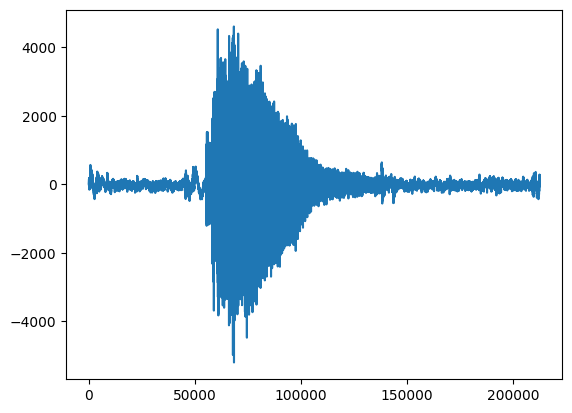

In [15]:
plt.plot(x)

(300.0, 720.0)

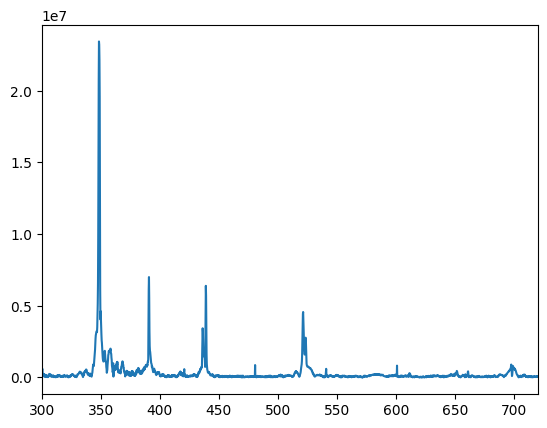

In [16]:
X = sp.fft.fft(x)
f = sp.fft.fftfreq(len(x), 1.0/samplerate) # для среза до каких частот надо
plt.plot(f[:len(f)//2], abs(X - np.mean(X))[:len(f)//2])
plt.xlim([300, 720])

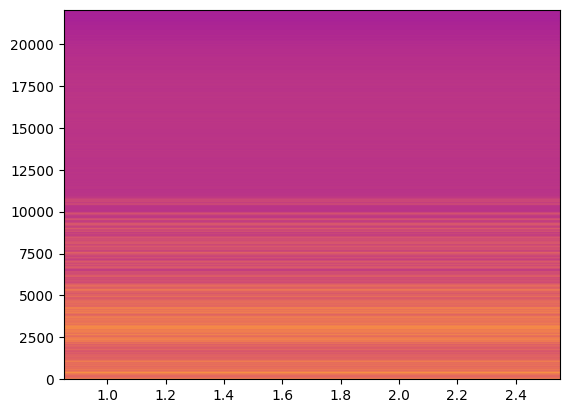

In [17]:
N = 150000 # количество точек
x_without_zeroes = list(filter(lambda el: el > 0.00001, x))
win = signal.get_window('hann', N) # оконное преобразование
# сглаженный гаусс
Sxx, ff, tt, img = plt.specgram(x, Fs=samplerate, NFFT=N, noverlap=N//2, window=win, cmap='plasma', mode='magnitude', scale='dB')

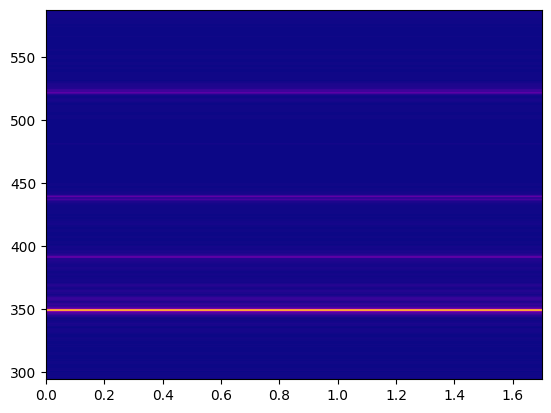

In [18]:
start_freq_index = 1000 # условные единицы по частоте
end_freq_index = 2000
Sxx_cropped = Sxx[start_freq_index:end_freq_index, :]
ff_cropped = ff[start_freq_index:end_freq_index]


plt.imshow(Sxx_cropped, extent=[0, tt[0], ff_cropped[0], ff_cropped[-1]], aspect='auto', origin='lower', cmap='plasma')


почистим от шума

(300.0, 720.0)

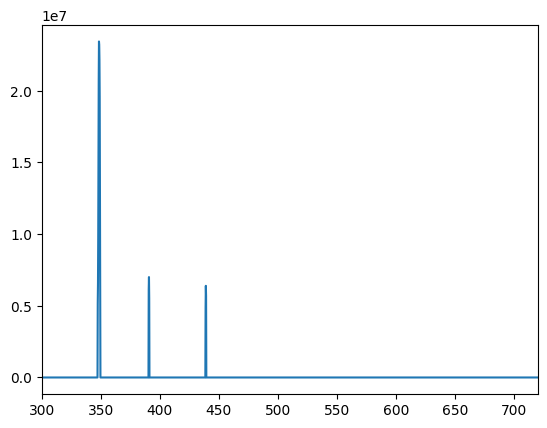

In [19]:
max_X = max(abs(X))
new_X = np.array(list(map(lambda el: el if abs(el) > max_X / 5 else 0, X))) # зануляем все что меньше максимума в 5 раз
plt.plot(f[:len(f)//2], abs(new_X)[:len(f)//2])
plt.xlim((300, 720))